# Imports

In [107]:
#math/viz
import numpy as np
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from collections import OrderedDict
import math
from tqdm import tqdm
from matplotlib import rcParams

#ML Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tabgan.sampler import GANGenerator


#data processing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import itertools

Pytorch CUDA Support

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



# Prepare Dataset of Hubble Telescope Data and Synthetic TableGAN-Generated Data

Data Manipulation and Aggregation

In [3]:
#get black hole data from popsycle dataset
pops = Table.read("data/popsycle_sim.fits").to_pandas()
ob = Table.read("data/OB110462_DW_post.fits").to_pandas()

for i in range(len(pops)):
    if (pops["mass_L"][i] < 6 and pops["mass_L"][i] > 2 and (pops["rem_id_L"][i] == 103)):
        print(f'{pops["mass_L"][i]}, {pops["rem_id_L"][i]}')
    else:
        pops = pops.drop([i])

pops.reset_index(inplace=True)
pops = pops.drop(columns=["index"])

wanted_ob = ["t0","u0_amp","tE","log10_thetaE","piE_E","muS_E","mL","piRel","muL_E","muRel_E"]
wanted_pops = ["t0","u0","t_E","theta_E","pi_E","mu_b_S","mass_L","pi_rel","mu_b_L","mu_rel"]

ob_to_pops = {"t0":"t0", "u0_amp":"u0","tE":"t_E","log10_thetaE":"theta_E","piE_E":"pi_E","muS_E":"mu_b_S","mL":"mass_L","piRel":"pi_rel","muL_E":"mu_b_L","muRel_E":"mu_rel"}

for col in [i for i in ob.columns]:
    if col in wanted_ob:
        pass
    else:
        ob = ob.drop(columns=[col])

for col in [i for i in pops.columns]:
    if col in wanted_pops:
        pass
    else:
        pops = pops.drop(columns=[col])

ob = ob.rename(columns=ob_to_pops, errors="raise")

ob_targets = {"target":[1 for i in range(len(ob))]}
pops_targets = {"target":[0 for i in range(len(pops))]}
target_ob = pd.DataFrame(ob_targets)
target_pops = pd.DataFrame(pops_targets)

5.928635293618626, 103.0
5.879971359489428, 103.0
5.162646276613792, 103.0
5.417679377687121, 103.0
5.93375031652569, 103.0
5.428512577551937, 103.0
5.945427577313886, 103.0
5.495947559658077, 103.0
5.928753878023536, 103.0
5.45393247635686, 103.0
5.851252711006547, 103.0
5.6768541171885465, 103.0
5.031358482509798, 103.0
5.901512804673876, 103.0
5.028441306942967, 103.0
5.963473680915251, 103.0
5.900972124119535, 103.0
5.751735432572209, 103.0


Normalize data

In [4]:
df_ob_ns_no_target = pd.concat([ob, pops], ignore_index=True)
df_ob_ns_only_target = pd.concat([target_ob,target_pops], ignore_index=True)
df_data_not_norm = pd.concat([df_ob_ns_no_target,df_ob_ns_only_target], axis=1)

norm_bh_ns = preprocessing.Normalizer()
df = norm_bh_ns.fit_transform(df_ob_ns_no_target)

Smote Tomek Upsample and Downsample Data

In [5]:
smk = SMOTETomek()
X,y=smk.fit_resample(df, df_ob_ns_only_target.to_numpy())

Split Data

In [6]:
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    #shuffle=False,
    random_state=42,
)

In [7]:
df_xtrain = pd.DataFrame(df_x_train, columns=df_ob_ns_no_target.columns).reset_index(drop=True)
df_xtest = pd.DataFrame(df_x_test, columns=df_ob_ns_no_target.columns).reset_index(drop=True)
df_ytrain = pd.DataFrame(df_y_train, columns=["id"]).reset_index(drop=True)
df_ytest = pd.DataFrame(df_y_test, columns=["id"]).reset_index(drop=True)

Train TABGAN for data synthesis

In [8]:
gen_x, gen_y = GANGenerator(
    gen_x_times=1.1, 
    cat_cols=None,
    bot_filter_quantile=0.001, 
    top_filter_quantile=0.999,
    is_post_process=True,
    adversarial_model_params={
        "metrics": "rmse", 
        "max_depth": 2, 
        "max_bin": 100, 
        "learning_rate": 0.02, 
        "random_state": 42, 
        "n_estimators": 500,
    }, 
    pregeneration_frac=2, 
    only_generated_data=False,
    gan_params = {
        "batch_size": 500, 
        "patience": 25, 
        "epochs" : 20,
    }).generate_data_pipe(
        df_xtrain, 
        df_ytrain,
        df_xtest, 
        deep_copy=True, 
        only_adversarial=False,
        use_adversarial=True
        )

Fitting CTGAN transformers for each column:   0%|          | 0/11 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/20 [00:00<?, ?it/s]

If above code results in NA or INF conversion issue, this is due to a large epoch count and overtraining - decrease the epoch count to solve this issue

Concatenate TableGAN data and real-world data

In [9]:
t = pd.concat([df_ob_ns_no_target,gen_x])
f = pd.concat([df_ob_ns_only_target,pd.DataFrame(gen_y.to_numpy(),columns=["target"])])
df_data = pd.concat([t,f], axis=1).reset_index(drop=True)

# Exploratory Data Analysis

In [36]:
eda_data = df_data.copy()

In [37]:
eda_data.head()

,t0,u0,t_E,theta_E,pi_E,mu_b_S,mass_L,pi_rel,mu_b_L,mu_rel,target
0,55763.312017,-0.051724,287.263116,0.728651,0.021247,0.066662,6.890218,0.510787,-1.449263,1.515925,1
1,55763.143207,-0.056239,273.684662,0.363211,0.019904,0.122164,2.534837,0.258013,-0.426201,0.548365,1
2,55762.869349,-0.059092,280.197751,0.597241,0.019986,0.031534,4.004285,0.479873,-0.818066,0.849601,1
3,55764.431058,-0.042804,279.152526,0.617667,0.025575,0.126121,5.574564,0.378698,-1.393074,1.519195,1
4,55762.025369,-0.067009,273.444603,0.572748,0.020906,0.060268,3.557838,0.482480,-0.748844,0.809112,1


In [38]:
eda_data.shape

(8999, 11)

In [39]:
eda_data.isna().sum().sum()

0

In [40]:
eda_data["target"].value_counts() #resample necessary

1    6126
0    2873
Name: target, dtype: int64

In [41]:
eda_data.dtypes

t0         float64
u0         float64
t_E        float64
theta_E    float64
pi_E       float64
mu_b_S     float64
mass_L     float64
pi_rel     float64
mu_b_L     float64
mu_rel     float64
target       int64
dtype: object

In [47]:
print(f"Skew:\n{eda_data.skew()}\n\nKurtosis:\n{eda_data.kurtosis()}")

Skew:
t0          0.493863
u0          4.797400
t_E         0.494311
theta_E     0.877515
pi_E        1.599983
mu_b_S     35.400529
mass_L      0.611195
pi_rel      0.622019
mu_b_L      2.985134
mu_rel     16.280924
target     -0.775533
dtype: float64

Kurtosis:
t0           -1.756489
u0          121.537479
t_E          -1.751878
theta_E       2.234090
pi_E          4.892270
mu_b_S     1612.190269
mass_L       -1.447218
pi_rel       -1.442326
mu_b_L      101.676150
mu_rel      390.471782
target       -1.398860
dtype: float64


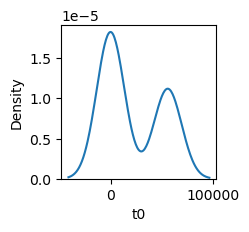

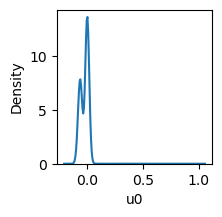

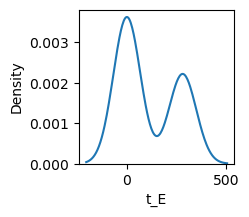

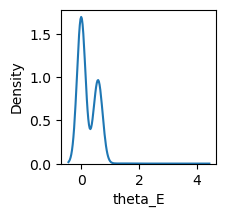

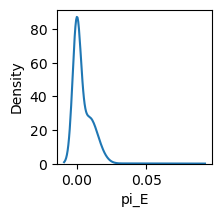

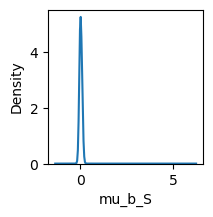

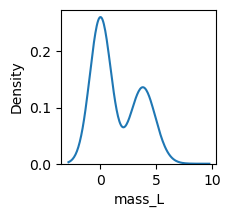

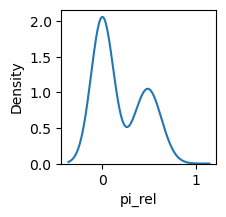

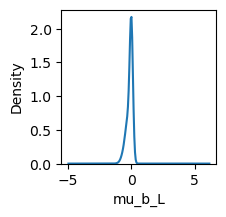

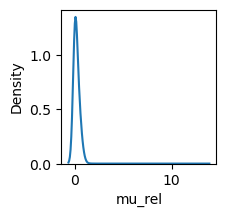

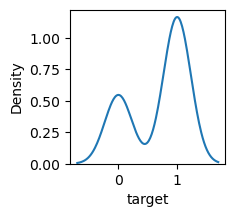

In [49]:
rcParams['figure.figsize'] = 2,2
for col in list(eda_data.columns):
    plt.figure()
    sns.kdeplot(eda_data[col],bw_method=0.5)

Observations:

1. Data is skewed harshly

# Preprocess Data

Smote tomek resample to make final data even

In [10]:
smk = SMOTETomek()
thing = df_data.drop(columns=["target"])
m_g_objects,m_g_targets=smk.fit_resample(thing, df_data["target"])

Train Test split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    m_g_objects,
    m_g_targets,
    test_size=0.2,
    #shuffle=False,
    random_state=42,
)

# Model Initialization and Architecture

Train the Following models on the synthetic data
1. Deep Belief Network
2. Radial Basis Function Network
3. Multilayer Perceptron Network

# Create Pytorch Tensors

In [12]:
class CustomDataset(Dataset):
 
  def __init__(self,m_g_objects,m_g_targets):
    x = m_g_objects.values
    y = m_g_targets.values
 
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [13]:
X_train = torch.tensor(x_train.values)
Y_train = torch.tensor(y_train.values)
X_test = torch.tensor(x_test.values)
Y_test = torch.tensor(y_test.values)

In [14]:
bh_ns = CustomDataset(x_train,y_train)
train_loader = DataLoader(bh_ns,batch_size=10,shuffle=False)

bh_ns_two = CustomDataset(x_test, y_test)
test_loader = DataLoader(bh_ns_two)

# DB NET

## Define and Train Deep Belief Network

1. Define a RBM: Restricted Boltzmann Machine

In [16]:
class RBM(nn.Module):
    '''
    This class defines all the functions needed for an BinaryRBN model
    where the visible and hidden units are both considered binary
    '''

    def __init__(self,
                visible_units=10,
                hidden_units = 64,
                k=2,
                learning_rate=1e-5,
                learning_rate_decay = False,
                xavier_init = False,
                increase_to_cd_k = False,
                use_gpu = False
                ):
        '''
        Defines the model
        W:Wheights shape (visible_units,hidden_units)
        c:hidden unit bias shape (hidden_units , )
        b : visible unit bias shape(visisble_units ,)
        '''
        super(RBM,self).__init__()
        self.desc = "RBM"

        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.k = k
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.xavier_init = xavier_init
        self.increase_to_cd_k = increase_to_cd_k
        self.use_gpu = use_gpu
        self.batch_size = 16


        # Initialization
        if not self.xavier_init:
            self.W = torch.randn(self.visible_units,self.hidden_units) * 0.01 #weights
        else:
            self.xavier_value = torch.sqrt(torch.FloatTensor([1.0 / (self.visible_units + self.hidden_units)]))
            self.W = -self.xavier_value + torch.rand(self.visible_units, self.hidden_units) * (2 * self.xavier_value)
        self.h_bias = torch.zeros(self.hidden_units) #hidden layer bias
        self.v_bias = torch.zeros(self.visible_units) #visible layer bias


    def to_hidden(self ,X):
        '''
        Converts the data in visible layer to hidden layer
        also does sampling
        X here is the visible probabilities
        :param X: torch tensor shape = (n_samples , n_features)
        :return -  X_prob - new hidden layer (probabilities)
                    sample_X_prob - Gibbs sampling of hidden (1 or 0) based
                                on the value
        '''
        X_prob = torch.matmul(X,self.W)
        X_prob = torch.add(X_prob, self.h_bias)#W.x + c
        X_prob  = torch.sigmoid(X_prob)

        sample_X_prob = self.sampling(X_prob)

        return X_prob,sample_X_prob

    def to_visible(self,X):
        '''
        reconstructs data from hidden layer
        also does sampling
        X here is the probabilities in the hidden layer
        :returns - X_prob - the new reconstructed layers(probabilities)
                    sample_X_prob - sample of new layer(Gibbs Sampling)

        '''
        # computing hidden activations and then converting into probabilities
        X_prob = torch.matmul(X ,self.W.transpose( 0 , 1) )
        X_prob = torch.add(X_prob , self.v_bias)
        X_prob = torch.sigmoid(X_prob)

        sample_X_prob = self.sampling(X_prob)

        return X_prob,sample_X_prob

    def sampling(self,prob):
        '''
        Bernoulli sampling done based on probabilities s
        '''
        s = torch.distributions.Bernoulli(prob).sample()
        return s

    def reconstruction_error(self , data):
        '''
        Computes the reconstruction error for the data
        handled by pytorch by loss functions
        '''
        return self.contrastive_divergence(data, False)

    def reconstruct(self , X,n_gibbs):
        '''
        This will reconstruct the sample with k steps of gibbs Sampling

        '''
        v = X
        for i in range(n_gibbs):
            prob_h_,h = self.to_hidden(v)
            prob_v_,v = self.to_visible(prob_h_)
        return prob_v_,v


    def contrastive_divergence(self, input_data ,training = True,
                                n_gibbs_sampling_steps=1,lr = 0.001):
        # positive phase

        positive_hidden_probabilities,positive_hidden_act  = self.to_hidden(input_data)

        # calculating W via positive side
        positive_associations = torch.matmul(input_data.t() , positive_hidden_act)



        # negetive phase
        hidden_activations = positive_hidden_act
        for i in range(n_gibbs_sampling_steps):
            visible_probabilities , _ = self.to_visible(hidden_activations)
            hidden_probabilities,hidden_activations = self.to_hidden(visible_probabilities)

        negative_visible_probabilities = visible_probabilities
        negative_hidden_probabilities = hidden_probabilities

        # calculating W via negative side
        negative_associations = torch.matmul(negative_visible_probabilities.t() , negative_hidden_probabilities)


        # Update parameters
        if(training):

            batch_size = self.batch_size

            g = (positive_associations - negative_associations)
            grad_update = g / batch_size
            v_bias_update = torch.sum(input_data - negative_visible_probabilities,dim=0)/batch_size
            h_bias_update = torch.sum(positive_hidden_probabilities - negative_hidden_probabilities,dim=0)/batch_size

            self.W += lr * grad_update
            self.v_bias += lr * v_bias_update
            self.h_bias += lr * h_bias_update


        # Compute reconstruction error
        error = torch.mean(torch.sum((input_data - negative_visible_probabilities)**2 , dim = 0))

        return error,torch.sum(torch.abs(grad_update))


    def forward(self,input_data):
        'data->hidden'
        return  self.to_hidden(input_data)
    def step(self,input_data,epoch,num_epochs):
        '''
            Includes the foward prop plus the gradient descent
            Use this for training
        '''
        if self.increase_to_cd_k:
            n_gibbs_sampling_steps = int(math.ceil((epoch/num_epochs) * self.k))
        else:
            n_gibbs_sampling_steps = self.k

        if self.learning_rate_decay:
            lr = self.learning_rate / epoch
        else:
            lr = self.learning_rate

        return self.contrastive_divergence(input_data , True,n_gibbs_sampling_steps,lr);


    def train(self,train_dataloader , num_epochs = 50,batch_size=16):

        self.batch_size = batch_size
        if(isinstance(train_dataloader ,torch.utils.data.DataLoader)):
            train_loader = train_dataloader
        else:
            train_loader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)


        for epoch in range(1 , num_epochs+1):
            epoch_err = 0.0
            n_batches = int(len(train_loader))
            # print(n_batches)

            cost_ = torch.FloatTensor(n_batches , 1)
            grad_ = torch.FloatTensor(n_batches , 1)

            for i,(batch,_) in tqdm(enumerate(train_loader),ascii=True,
                                desc="RBM fitting", file=sys.stdout):

                batch = batch.view(len(batch) , self.visible_units)
                
                if(self.use_gpu):
                    batch = batch.cuda()
                cost_[i-1],grad_[i-1] = self.step(batch,epoch,num_epochs)


            print("Epoch:{} ,avg_cost = {} ,std_cost = {} ,avg_grad = {} ,std_grad = {}".format(epoch,\
                                                            torch.mean(cost_),\
                                                            torch.std(cost_),\
                                                            torch.mean(grad_),\
                                                            torch.std(grad_)))

        return

2. DBN Based on RBM

In [17]:
class DBN(nn.Module):
    def __init__(self,
                visible_units = 10,
                hidden_units = [64 , 100],
                k = 2,
                learning_rate = 1e-5,
                learning_rate_decay = False,
                xavier_init = False,
                increase_to_cd_k = False,
                use_gpu = False
                ):
        super(DBN,self).__init__()

        self.n_layers = len(hidden_units)
        self.rbm_layers =[]
        self.rbm_nodes = []

        # Creating different RBM layers
        for i in range(self.n_layers ):
            input_size = 0
            if i==0:
                input_size = visible_units
            else:
                input_size = hidden_units[i-1]
            rbm = RBM(visible_units = input_size,
                    hidden_units = hidden_units[i],
                    k= k,
                    learning_rate = learning_rate,
                    learning_rate_decay = learning_rate_decay,
                    xavier_init = xavier_init,
                    increase_to_cd_k = increase_to_cd_k,
                    use_gpu=use_gpu)

            self.rbm_layers.append(rbm)

        # rbm_layers = [RBM(rbn_nodes[i-1] , rbm_nodes[i],use_gpu=use_cuda) for i in range(1,len(rbm_nodes))]
        self.W_rec = [nn.Parameter(self.rbm_layers[i].W.data.clone()) for i in range(self.n_layers-1)]
        self.W_gen = [nn.Parameter(self.rbm_layers[i].W.data) for i in range(self.n_layers-1)]
        self.bias_rec = [nn.Parameter(self.rbm_layers[i].h_bias.data.clone()) for i in range(self.n_layers-1)]
        self.bias_gen = [nn.Parameter(self.rbm_layers[i].v_bias.data) for i in range(self.n_layers-1)]
        self.W_mem = nn.Parameter(self.rbm_layers[-1].W.data)
        self.v_bias_mem = nn.Parameter(self.rbm_layers[-1].v_bias.data)
        self.h_bias_mem = nn.Parameter(self.rbm_layers[-1].h_bias.data)

        for i in range(self.n_layers-1):
            self.register_parameter('W_rec%i'%i, self.W_rec[i])
            self.register_parameter('W_gen%i'%i, self.W_gen[i])
            self.register_parameter('bias_rec%i'%i, self.bias_rec[i])
            self.register_parameter('bias_gen%i'%i, self.bias_gen[i])


    def forward(self , input_data):
        '''
            running the forward pass
            do not confuse with training this just runs a foward pass
        '''
        v = input_data
        for i in range(len(self.rbm_layers)):
            v = v.view((v.shape[0] , -1)).type(torch.FloatTensor)#flatten
            p_v,v = self.rbm_layers[i].to_hidden(v)
        return p_v,v

    def reconstruct(self,input_data):
        '''
        go till the final layer and then reconstruct
        '''
        h = input_data
        p_h = 0
        for i in range(len(self.rbm_layers)):
            h = h.view((h.shape[0] , -1)).type(torch.FloatTensor)#flatten
            p_h,h = self.rbm_layers[i].to_hidden(h)

        v = h
        for i in range(len(self.rbm_layers)-1,-1,-1):
            v = v.view((v.shape[0] , -1)).type(torch.FloatTensor)
            p_v,v = self.rbm_layers[i].to_visible(v)
        return p_v,v



    def train_static(self, train_data,train_labels,num_epochs=50,batch_size=10):
        '''
        Greedy Layer By Layer training
        Keeping previous layers as static
        '''

        tmp = train_data

        for i in range(len(self.rbm_layers)):
            print("-"*20)
            print("Training the {} st rbm layer".format(i+1))

            tensor_x = tmp.type(torch.FloatTensor) # transform to torch tensors
            tensor_y = train_labels.type(torch.FloatTensor)
            _dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
            _dataloader = torch.utils.data.DataLoader(_dataset,batch_size=batch_size,drop_last = True) # create your dataloader

            self.rbm_layers[i].train(_dataloader , num_epochs,batch_size)
            # print(train_data.shape)
            v = tmp.view((tmp.shape[0] , -1)).type(torch.FloatTensor)#flatten
            p_v , v = self.rbm_layers[i].forward(v)
            tmp = v
            # print(v.shape)
        return

    def train_ith(self, train_data,train_labels,num_epochs,batch_size,ith_layer):
        '''
        taking ith layer at once
        can be used for fine tuning
        '''
        if(ith_layer-1>len(self.rbm_layers) or ith_layer<=0):
            print("Layer index out of range")
            return
        ith_layer = ith_layer-1
        v = train_data.view((train_data.shape[0] , -1)).type(torch.FloatTensor)

        for ith in range(ith_layer):
            p_v, v = self.rbm_layers[ith].forward(v)

        tmp = v
        tensor_x = tmp.type(torch.FloatTensor) # transform to torch tensors
        tensor_y = train_labels.type(torch.FloatTensor)
        _dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
        _dataloader = torch.utils.data.DataLoader(_dataset , batch_size=batch_size,drop_last=True)
        self.rbm_layers[ith_layer].train(_dataloader, num_epochs,batch_size)
        return

3. Train DBN

In [31]:
dbn_bhns = DBN(visible_units=10 ,
                hidden_units=[23*23 ,1*1] ,
                k = 5,
                learning_rate = 0.01,
                learning_rate_decay = True,
                xavier_init = True,
                increase_to_cd_k = False,
                use_gpu = False)

Change use_gpu to True when training with CUDA accelerator

In [32]:
dbn_bhns.train_static(X_train, Y_train, 20, batch_size=10)

--------------------
Training the 1 st rbm layer
RBM fitting: 1003it [00:09, 110.46it/s]
Epoch:1 ,avg_cost = 842260416.0 ,std_cost = 426686528.0 ,avg_grad = 4462930.5 ,std_grad = 2260999.0
RBM fitting: 1003it [00:08, 115.51it/s]
Epoch:2 ,avg_cost = 842260416.0 ,std_cost = 426686528.0 ,avg_grad = 4463364.5 ,std_grad = 2261053.75
RBM fitting: 1003it [00:08, 125.30it/s]
Epoch:3 ,avg_cost = 842260416.0 ,std_cost = 426686528.0 ,avg_grad = 4463370.0 ,std_grad = 2261068.0
RBM fitting: 1003it [00:08, 120.64it/s]
Epoch:4 ,avg_cost = 842260416.0 ,std_cost = 426686528.0 ,avg_grad = 4463377.0 ,std_grad = 2261071.75
RBM fitting: 1003it [00:08, 112.34it/s]
Epoch:5 ,avg_cost = 842260416.0 ,std_cost = 426686528.0 ,avg_grad = 4463382.5 ,std_grad = 2261070.5
RBM fitting: 1003it [00:08, 120.53it/s]
Epoch:6 ,avg_cost = 842260416.0 ,std_cost = 426686528.0 ,avg_grad = 4463388.0 ,std_grad = 2261070.5
RBM fitting: 1003it [00:07, 126.51it/s]
Epoch:7 ,avg_cost = 842260416.0 ,std_cost = 426686528.0 ,avg_grad = 4

Model Save

In [33]:
torch.save(dbn_bhns.state_dict(),"Deep_Belief_Network.pth")

Model Load

In [35]:
loaded_model = DBN(visible_units=10 ,
                hidden_units=[23*23 ,1*1] ,
                k = 5,
                learning_rate = 0.01,
                learning_rate_decay = True,
                xavier_init = True,
                increase_to_cd_k = False,
                use_gpu = False)

loaded_model.load_state_dict(torch.load("Deep_Belief_Network.pth"))

<All keys matched successfully>

## Deep Belief Network Evaluation

In [41]:
predictions = dbn_bhns(X_test)[1].detach().cpu().numpy().astype(int)
actuals = Y_test.detach().cpu().numpy()

accuracy = accuracy_score(actuals, predictions)
f1 = f1_score(actuals, predictions)
precision = precision_score(actuals, predictions, average=None)
recall = recall_score(actuals, predictions, average=None)

print(f"Accuracy: {accuracy}, f1-score: {f1}, Precision: {precision}, Recall: {recall}")

Accuracy: 0.5105619768832204, f1-score: 0.6759894459102902, Precision: [0.         0.51056198], Recall: [0. 1.]


# RBF NET

## Define and Train Radial Basis Function Network

In [42]:
class RBF(nn.Module):
   
    def __init__(self, in_features, out_features, basis_func):
        super(RBF, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centres = nn.Parameter(torch.Tensor(out_features, in_features))
        self.log_sigmas = nn.Parameter(torch.Tensor(out_features))
        self.basis_func = basis_func
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.centres, 0, 1)
        nn.init.constant_(self.log_sigmas, 0)

    def forward(self, input):
        size = (input.size(0), self.out_features, self.in_features)
        x = input.unsqueeze(1).expand(size)
        c = self.centres.unsqueeze(0).expand(size)
        distances = (x - c).pow(2).sum(-1).pow(0.5) / torch.exp(self.log_sigmas).unsqueeze(0)
        return self.basis_func(distances)



# RBFs

def gaussian(alpha):
    phi = torch.exp(-1*alpha.pow(2))
    return phi

def linear(alpha):
    phi = alpha
    return phi

def quadratic(alpha):
    phi = alpha.pow(2)
    return phi

def inverse_quadratic(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2))
    return phi

def multiquadric(alpha):
    phi = (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def inverse_multiquadric(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def spline(alpha):
    phi = (alpha.pow(2) * torch.log(alpha + torch.ones_like(alpha)))
    return phi

def poisson_one(alpha):
    phi = (alpha - torch.ones_like(alpha)) * torch.exp(-alpha)
    return phi

def poisson_two(alpha):
    phi = ((alpha - 2*torch.ones_like(alpha)) / 2*torch.ones_like(alpha)) \
    * alpha * torch.exp(-alpha)
    return phi

def matern32(alpha):
    phi = (torch.ones_like(alpha) + 3**0.5*alpha)*torch.exp(-3**0.5*alpha)
    return phi

def matern52(alpha):
    phi = (torch.ones_like(alpha) + 5**0.5*alpha + (5/3) \
    * alpha.pow(2))*torch.exp(-5**0.5*alpha)
    return phi

def basis_func_dict():
   
    bases = {'gaussian': gaussian,
             'linear': linear,
             'quadratic': quadratic,
             'inverse quadratic': inverse_quadratic,
             'multiquadric': multiquadric,
             'inverse multiquadric': inverse_multiquadric,
             'spline': spline,
             'poisson one': poisson_one,
             'poisson two': poisson_two,
             'matern32': matern32,
             'matern52': matern52}
    return bases

In [43]:
class RadialBasisNet(nn.Module):
    
    def __init__(self, layer_widths, layer_centres, basis_func):
        super(RadialBasisNet, self).__init__()
        self.rbf_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        for i in range(len(layer_widths) - 1):
            self.rbf_layers.append(RBF(layer_widths[i], layer_centres[i], basis_func))
            self.linear_layers.append(nn.Linear(layer_centres[i], layer_widths[i+1]))
    
    def forward(self, x):
        out = x
        for i in range(len(self.rbf_layers)):
            out = self.rbf_layers[i](out)
            out = self.linear_layers[i](out)
        return out
    
    def fit(self, epochs, lr, loss_func):
        self.train()
        obs = torch.tensor(x_train.to_numpy()).size(0)
        trainloader = train_loader
        optimiser = torch.optim.Adam(self.parameters(), lr=lr)
        epoch = 0
        while epoch < epochs:
            epoch += 1
            current_loss = 0
            batches = 0
            progress = 0
            for x_batch, y_batch in trainloader:
                batches += 1
                optimiser.zero_grad()
                y_hat = self.forward(x_batch)
                print(y_hat.shape,y_batch.shape)
                y_batch = y_batch.unsqueeze(1)
                loss = loss_func(y_hat, y_batch)
                current_loss += (1/batches) * (loss.item() - current_loss)
                loss.backward()
                optimiser.step()
                progress += y_batch.size(0)
                sys.stdout.write('\rEpoch: %d, Progress: %d/%d, Loss: %f      ' % \
                                 (epoch, progress, obs, current_loss))
                sys.stdout.flush()


In [ ]:
layer_widths = [10, 1]
layer_centres = [40]
basis_func = gaussian

rbfnet = RadialBasisNet(layer_widths, layer_centres, basis_func)
rbfnet.fit(500, 0.01, nn.BCEWithLogitsLoss())
rbfnet.eval()

Model Saving

In [ ]:
torch.save(rbfnet.state_dict(),"Radial_Basis_Function_Net.pth")

Load Model

In [69]:
layer_widths = [10, 1]
layer_centres = [40]
basis_func = gaussian

rbfnet = RadialBasisNet(layer_widths, layer_centres, basis_func)
rbfnet.load_state_dict(torch.load("Radial_Basis_Function_Net.pth"))

<All keys matched successfully>

## Radial Basis Function Network Evaluation

In [70]:
preds, actuals = list(), list()
for i, (xdat, ydat) in enumerate(test_loader):
    thing = rbfnet(xdat).detach().cpu().tolist()[0]
    if thing[0] > 0:

        preds.append([1])
    else:
        preds.append([0])
        
    actuals.append(ydat.detach().cpu().tolist()[0])

predictions = np.asarray(preds)
actuals = np.asarray(actuals)

accuracy = accuracy_score(actuals, predictions)
f1 = f1_score(actuals, predictions)
precision = precision_score(actuals, predictions, average=None)
recall = recall_score(actuals, predictions, average=None)

print(f"Accuracy: {accuracy}, f1-score: {f1}, Precision: {precision}, Recall: {recall}")

Accuracy: 0.9828616978876046, f1-score: 0.9830374753451677, Precision: [0.97211155 0.99362041], Recall: [0.99348534 0.9726776 ]


# MLP NET

## Define and Train Multilayer Perceptron Network

Define model architecture

In [60]:
mpnet = nn.Sequential(OrderedDict([
    ('dense1', nn.Linear(10, 100)),
    ('act1', nn.ReLU()),
    ('dense2', nn.Linear(100, 50)),
    ('act2', nn.ReLU()),
    ('output', nn.Linear(50, 1)),
    ('outact', nn.Sigmoid()),
]))

Train Model

In [64]:
epochs = 100
loss_fn = nn.BCELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(mpnet.parameters(), lr=learning_rate)

epoch = 0
while epoch < epochs:
    epoch += 1
    batches = 0
    progress = 0
    for x_batch, y_batch in train_loader:
        batches += 1
        optimizer.zero_grad()

        y_pred = mpnet(x_batch)
        y_batch = y_batch.unsqueeze(1)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        progress += y_batch.size(0)

        if progress % 15 == 0:
            sys.stdout.write('\rEpoch: %d, Progress: %d, Loss: %f      ' % 
                                (epoch, progress, loss))
            sys.stdout.flush()

Epoch: 100, Progress: 10020, Loss: 0.000076      

Model Saving

In [65]:
torch.save(mpnet.state_dict(),"Multilayer_Perceptron_Net.pth")

In [66]:
loaded_model = nn.Sequential(OrderedDict([
    ('dense1', nn.Linear(10, 100)),
    ('act1', nn.ReLU()),
    ('dense2', nn.Linear(100, 50)),
    ('act2', nn.ReLU()),
    ('output', nn.Linear(50, 1)),
    ('outact', nn.Sigmoid()),
]))

loaded_model.load_state_dict(torch.load("Multilayer_Perceptron_Net.pth"))

<All keys matched successfully>

Load Model

## Multilayer Perceptron Network Evaluation

In [67]:
preds, actuals = list(), list()
for i, (xdat, ydat) in enumerate(test_loader):
    thing = mpnet(xdat).detach().cpu().tolist()[0]
    if thing[0] >= 0.5:

        preds.append([1])
    else:
        preds.append([0])
        
    actuals.append(ydat.detach().cpu().tolist()[0])

predictions = np.asarray(preds)
actuals = np.asarray(actuals)

accuracy = accuracy_score(actuals, predictions)
f1 = f1_score(actuals, predictions)
precision = precision_score(actuals, predictions, average=None)
recall = recall_score(actuals, predictions, average=None)

print(f"Accuracy: {accuracy}, f1-score: {f1}, Precision: {precision}, Recall: {recall}")

Accuracy: 0.986050219210841, f1-score: 0.9861932938856016, Precision: [0.9752988  0.99681021], Recall: [0.99674267 0.97580016]


# Model by Model Evaluation

### Graph Confusion Matrices

In [94]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [104]:
def confmatr(model,X_test,y_true,isbeliefNet,test_loader=test_loader):
    if isbeliefNet:
        y_true = y_true.detach().cpu().numpy().tolist()
        y_pred = list(itertools.chain.from_iterable(model(X_test)[1].detach().cpu().numpy().astype(int).tolist()))

    else:
        preds, actuals = list(), list()
        for i, (xdat, ydat) in enumerate(test_loader):
            thing = model(xdat).detach().cpu().tolist()[0]
            if thing[0] > 0:

                preds.append([1])
            else:
                preds.append([0])
                
            actuals.append(ydat.detach().cpu().tolist()[0])
            
        y_true = actuals
        y_pred = list(itertools.chain.from_iterable(preds))
        
    conf_arr = confusion_matrix(y_true, y_pred, labels=[0,1])
    labels = ['True Neg','False Pos','False Neg','True Pos']
    categories = ['Black Hole', 'Neutron Star']
    make_confusion_matrix(conf_arr, 
                        group_names=labels,
                        categories=categories, 
                        cmap='Blues')

DBN

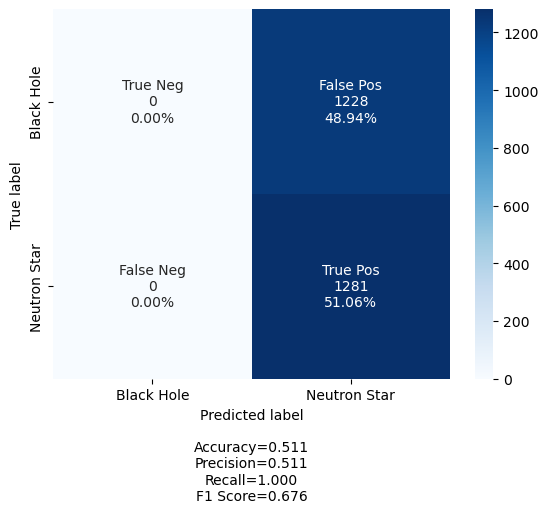

In [102]:
confmatr(model=dbn_bhns,X_test=X_test,y_true=Y_test, isbeliefNet=True)

RBFN

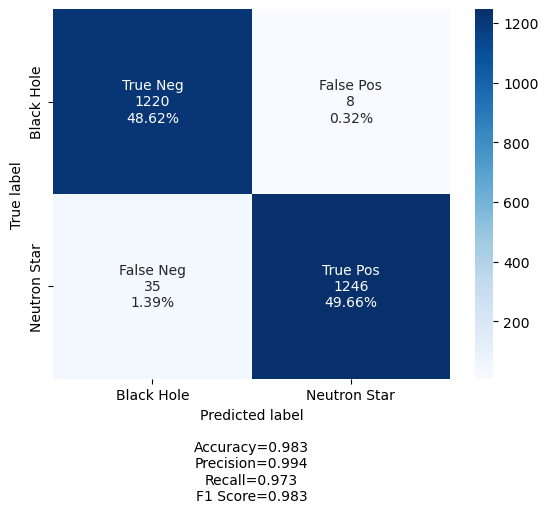

In [105]:
confmatr(model=rbfnet,X_test=X_test,y_true=Y_test,isbeliefNet=False)

MLP

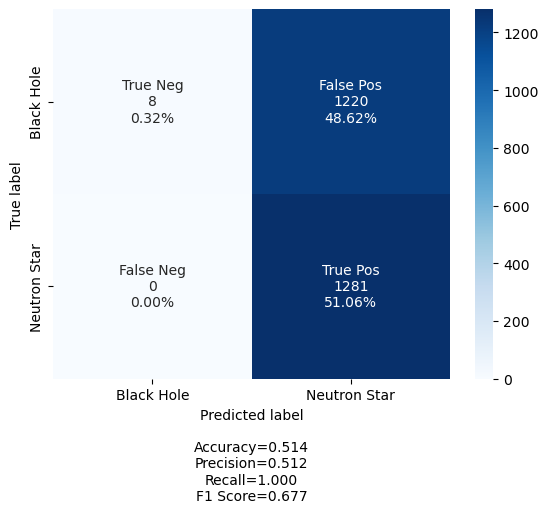

In [106]:
confmatr(model=mpnet,X_test=X_test,y_true=Y_test,isbeliefNet=False)

## Graph Model Vs. Model Performance Charts

Graph Decision Boundaries